# Progetto per la Multimedia e Laboratorio: Steganografia

Il progetto tratta della steganografia che è una tecnica per nascondere un'informazione o  in un mezzo multimediale.
Lo scopo del progetto è quello di approfondire le tecniche di Steganografia applicata alle immagini, nascondendo una stringa contenente un messaggio o una immagine più piccola.
Inizialmente verrà applicata la tencica della LSB, poi la DCT e altre tecniche.
<br> <b> Definizione di Steganografia: </b> <br> **La steganografia è una tecnica che si prefigge di nascondere la comunicazione tra due interlocutori.**


Si inizia con LSB una tecnica che utilizzerà i bit meno significativi dell'immagine per nascondere i messaggi di ogni genere. Questo ha lo scopo di rendere il messaggio percettivamente invisibile ma nella pratica sono salvati nei bit meno significativi. Come vedremo tra poco, si vedrà come applicare questa tecnica e se resiste agli attacchi attraverso un determinato rumore.


In [1]:
# librerie da utilizzare:

import os
from PIL import Image 
import scipy.ndimage 
import cv2
import numpy as np
from skimage.io import imread 
import matplotlib.pyplot as plt
from LSBSteg import LSBSteg
from LSBSteg import ImageWrapper
from DCT import DCT
from DCT import Compare
from DCT_image import *

Carichiamo l'immagine interessata usando la funzione presente in cv2 (imread) e successivamente usiamo la funzioni presenti nella libreria LSBSteg.
Usiamo inoltre "encode_text()" per introdurre il messaggio da nascondere il quale nel nostro caso sarà "Hello World!!!":

In [2]:
TextString="HelloWorld!!!"
PathOriginalImage = "images/lena.png"
PathNewImage = "images/HelloWorldLena.png"
ims=cv2.imread(PathOriginalImage)
steg = LSBSteg(ims)
img_enc=steg.encode_text(TextString)
cv2.imwrite(PathNewImage,img_enc)


True

Abbiamo salvato l'immagine codificata  nella stessa cartella in cui si trova l'immagine originale.
Adesso proviamo a decodifica l'immagine traendone decodificando il messaggio. Come segue:

In [3]:
imd = cv2.imread(PathNewImage)
if imd is None:
    print("il file non è stato trovato")
steg = LSBSteg(imd)
print("Il  testo nascosto nell'immagine è ", steg.decode_text())

Il  testo nascosto nell'immagine è  HelloWorld!!!


Adesso passiamo la codifica di un immagine usando sempre la tecnica dell'LSB:

In [4]:
PathHidden = "images/133.png"
ims = cv2.imread(PathOriginalImage)
steg = LSBSteg(ims)
imf = cv2.imread(PathHidden)
x, y, z= imf.shape
x1, y1, z1= ims.shape
#perfetto, ho fatto un controllo in cui se da nascondere è più grande dell'immagine portante allora lui ridimensiona l'immagine da nascondere.
if x> x1 or y>y1 :
    imf = cv2.resize(imf, (int(x/4),int(y/4)))
# Wrappiamo l'immagine imf in modo da fornire gli attributi width e height
wrapped_image = ImageWrapper(imf)

# Passiamo l'immagine wrappata al metodo encode_image
img_enc = steg.encode_image(wrapped_image)  # Nascondi l'immagine qui
cv2.imwrite("images/LenaNew.png", img_enc)



True

Adesso la codificata è salvata, una volta che tutto sia andato bene, facciamo la decodifica:

In [5]:
imss = cv2.imread("images/LenaNew.png")
steg = LSBSteg(imss)
unhideimg = LSBSteg.decode_image(steg)
# Salviamo l'immagine recuperata
cv2.imwrite("recovered.png", unhideimg)

True

**Visualizziamo usando la libreria matplotlib:**


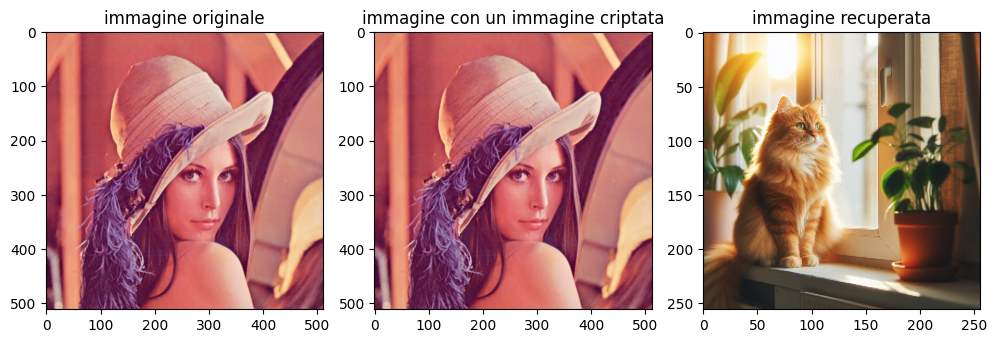

In [6]:
# Visualizzazione
fig = plt.figure(figsize=(10,7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(ims, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine originale')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.cvtColor(imss, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine con un immagine criptata')


fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(unhideimg, cv2.COLOR_BGR2RGB))
plt.axis('on')

plt.title('immagine recuperata')
plt.tight_layout()
plt.show()

**Applicazione Rumore Gaussiano: <br>**
Adesso, proviamo a introdurre un rumore per vedere cosa accade per semplicità introduco il rumore gaussiano (o normale). 
Per cui, a livello di codice dovrà aggiungere all'immagine iniziale un rumore con distribuzione a campana generata dalla seguente funzione matematica: <br> &emsp;
$f(x) =\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu )^2}{2 \sigma^2}} $ <br>

All'interno della libreria *LSBSteg* questa funzione matematica è trasposta in python come : 
<br>
<p>
def gaussian_noisy(self, mean, sigma): #mean = media, sigma=dev.std. <br> &emsp;&emsp;
        x1, y1, z1 = self.shape <br> &emsp;&emsp;
        # Creazione del rumore gaussiano con float32 per evitare overflow <br> &emsp;&emsp;
        gauss_noise = np.random.normal(mean, sigma, (x1, y1, z1)).astype(np.float32) <br> &emsp;&emsp;
        # Conversione dell'immagine a float32 per somma senza overflow <br> &emsp;&emsp;
        noisy_image = self.astype(np.float32) + gauss_noise <br> &emsp;&emsp;
        # Clipping dei valori nel range 0-255 e conversione a uint8<br> &emsp;&emsp;
        gn_img = np.clip(noisy_image, 0, 255).astype(np.uint8) <br> &emsp;&emsp;
        return gn_img <br>&emsp; 

</p>


In [7]:
m= 0
s= 10
gn_image=LSBSteg.gaussian_noisy(imss, m, s)  
gn_image_text=LSBSteg.gaussian_noisy(imd, m, s)
cv2.imwrite("images/image_noisy.png", gn_image)
cv2.imwrite("images/image_noisy_text.png", gn_image_text)
# se noi provassimo a eseguire il recupero dei bit l'algoritmo darà un errore poiché la maggiorparte deio bit andranno persi
# poiché l'immagine a cui facciamo riferimento 

#dopo averla salvata, proviamo a capire se effettivamente l'immagine presenta ancora l'immagine criptata
try:
    imr = cv2.imread("images/image_noisy.png")
    steg1 = LSBSteg(imr)
    unhideimg1 = LSBSteg.decode_image(steg1)
    
except Exception as e:
    print("L'immagine nascosta sarà stata distrutta dal rumore")
try:
    imt=cv2.imread("images/image_noisy_text.png")
    steg1= LSBSteg(imt)
    decriptText = LSBSteg.decode_text(steg1)
    if TextString != decriptText :
        print(" Non sono la stessa stringa, poiché qualche rumore avrà alterato il contenuto della stringa. ")
except Exception as e:
    print(" il testo sarà stata distrutta dal rumore.") 



L'immagine nascosta sarà stata distrutta dal rumore
 Non sono la stessa stringa, poiché qualche rumore avrà alterato il contenuto della stringa. 


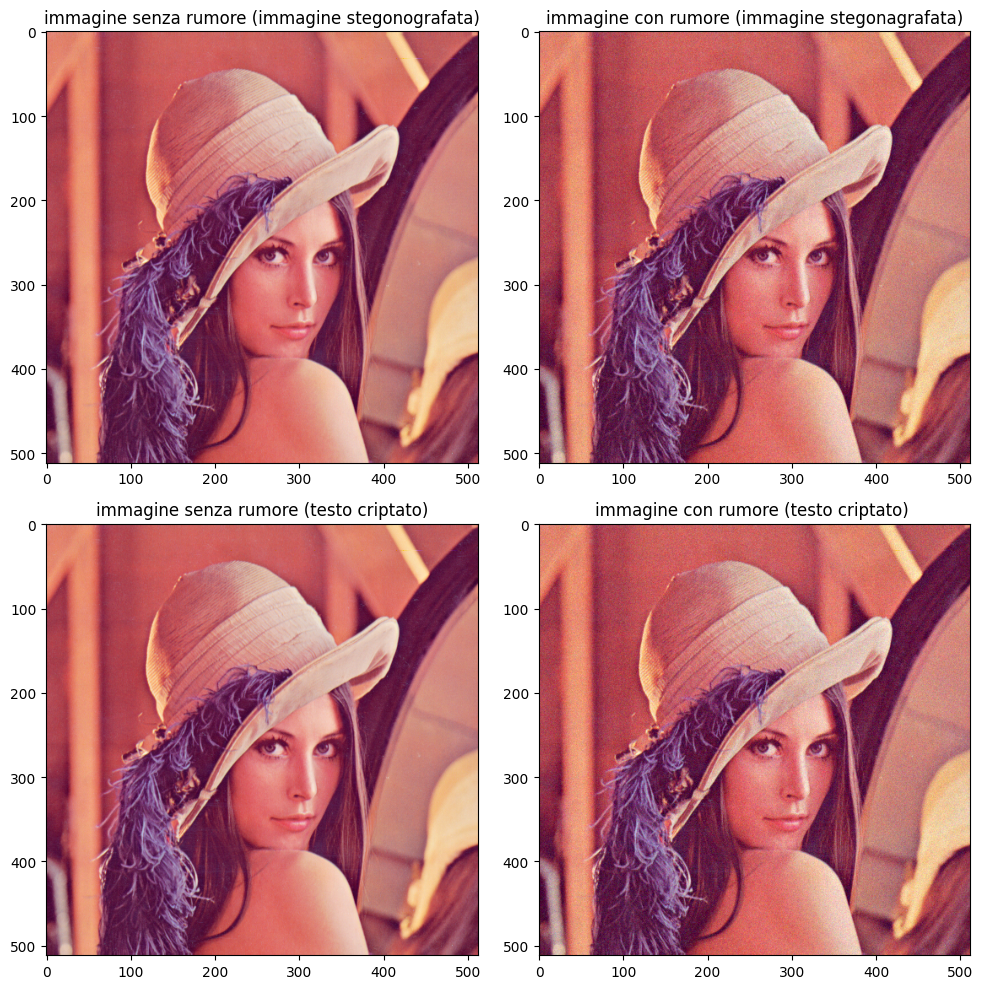

In [8]:
# per comodità plottiamo le due immagini : prima del rumore e dopo il rumore (gaussiano) in modo tale vediamo il lato percettivo.
# Visualizzazione
fig = plt.figure(figsize=(10,10))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(imss, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine senza rumore (immagine stegonografata)')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.cvtColor(gn_image, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine con rumore (immagine stegonagrafata)')


fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(imd, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine senza rumore (testo criptato)')

fig.add_subplot(rows, columns, 4)
plt.imshow(cv2.cvtColor(gn_image_text, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine con rumore (testo criptato) ')

plt.tight_layout()
plt.show()


**Adesso passiamo alla trasformata discreta del coseno**: <br>
La trasformata discreta del coseno (spesso chiamata anche Discrete Cosine Trasform con la sua abbrebreviazione DCT) è una trasformata usata per la compressione spaziale, per cui, questo tipo di trasformata riesce a comprimere rilevando le ridondanze e conseguenmente attenuarle. Inoltre, è usata per i formati più conosciuti, come ad esempio il formato JPEG.
A differenza della tecnica LSB (least significant bit) di cui applicazione visto in precedenza, l'informazione da nascondere non sarà più nascosta  nei bit meno significativi,  ma nei coefficienti a frequenza medio-bassa poiché se si scegliessero i coefficienti troppi bassi si alterarebbero la qualità dell'immagine, mentre viceversa, se si dovessero scegliere dei coefficienti troppo alti tendono a essere eliminati con facilità. Per cui, il giusto compromesso è prendere i coefficienti medio-bassi.
La formula per la trasformata discreta del coseno è la seguente:

 $X_k= \alpha (k)\sum_{n=0}^{N-1} x_n cos[ \frac{\pi}{N}(n+\frac{1}{2})k ] $ <br>
Dove:<br>
* $ \alpha (k) \sqrt{\frac{1}{N}}$ per $k= 0 $ e $\alpha(k) = \sqrt{\frac{2}{N}}$ per $k>0 $
* $X_k$ è il coefficiente della DCT per indice k,
* $x_n$ è il valore della sequenza di ingresso al punto n,
* k varia da <b>0 </b> a <b> N-1 </b>,
* N è la lunghezza della sequenza.

In [9]:
img2=cv2.imread("images/lena.png")
stegDCT = DCT() 
#codifichiamo il messaggio
imageDCT = stegDCT.encode_image(img2,"Hello World!")
cv2.imwrite("images/DCTLena.png", imageDCT)

True

In [10]:
# Decodifichiamo:

imgEnc = cv2.imread("images/DCTLena.png")
textDec = stegDCT.decode_image(imgEnc)
print("ecco qui: ",textDec)

ecco qui:  Hello World!


Visualizziamo :

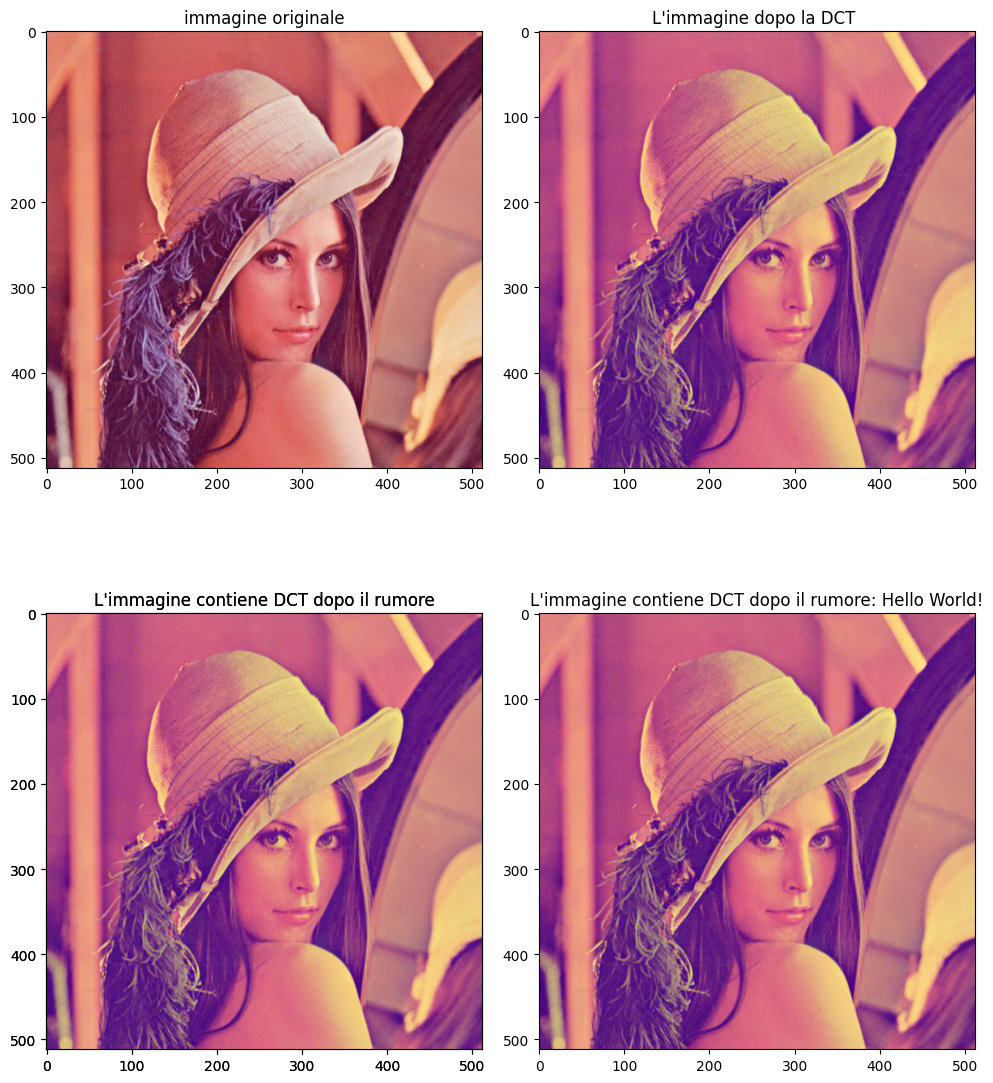

Hello World!


In [11]:
imgNoisy=LSBSteg.gaussian_noisy(imgEnc, 0, 0.000001)  
#rispetto alla LSB resiste per leggerissimi rumori ma appena c'è un rumore in più l'immagine non riesce a salvare il contenuto (0.00001)
fig = plt.figure(figsize=(10,12))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title('immagine originale')
fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.cvtColor(imgEnc, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title("L'immagine dopo la DCT ")
fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(imgNoisy, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title("L'immagine contiene DCT dopo il rumore")
fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(imgNoisy, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title("L'immagine contiene DCT dopo il rumore")
textDec = stegDCT.decode_image(imgNoisy)
fig.add_subplot(rows, columns, 4)
plt.imshow(cv2.cvtColor(imgNoisy, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title("L'immagine contiene DCT dopo il rumore: " + textDec)
plt.tight_layout()
plt.show()

print(textDec)


Proviamo adesso a nascondere un immagine utilizzando la trasformata  DCT:


In [12]:
dct_image = DCT_image()

host_img_path = "images/lena.png"
target_img_path = "images/133.png"
# Carica le immagini host e target
host_img = cv2.imread(host_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)
target_img = cv2.resize(target_img, (host_img.shape[1], host_img.shape[0]))

# Fase di encoding: nascondi target dentro host tramite DCT
encoded_img = dct_image.encode_image_with_image(host_img, target_img)
cv2.imwrite("encoded_image.png", encoded_img)

# Verifica della decodifica senza trasformazioni
decoded_img = dct_image.decode_image_with_image(encoded_img, host_img)
cv2.imwrite("decoded_image.png", decoded_img)


# Comprimiamo l'immagine encoded

quality_image = 50
compressed_image = compress_image(encoded_img, quality_image)
cv2.imwrite("compress_image.jpeg", compressed_image)
decoded_img_after_compression = dct_image.decode_image_with_image(compressed_image, host_img)
cv2.imwrite("decoded_compres_image.jpeg", decoded_img_after_compression)

#qui comincia , forse conviene fare una funzione a parte

affine_corrected = create_translation(encoded_img)
cv2.imwrite("affine_corrected.jpeg", affine_corrected)

# Decodifica l'immagine corretta
decoded_affine = dct_image.decode_image_with_image(affine_corrected, host_img)
cv2.imwrite("decoded_aff.jpeg", decoded_affine)

True

Vediamo i risultati che abbiamo nascondendo l'immagine usando la trasformata del coseno:

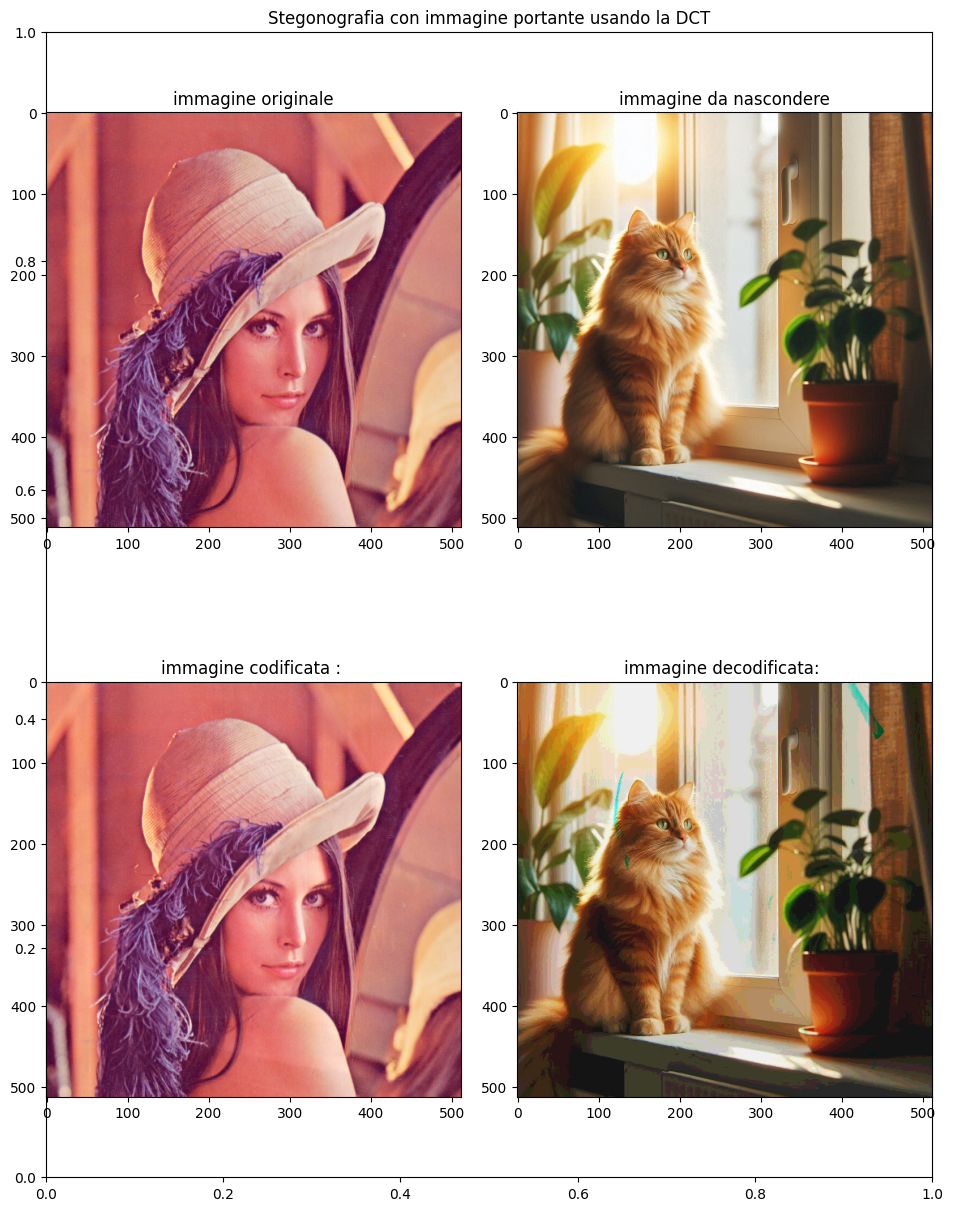

In [13]:
fig = plt.figure(figsize=(10,12))
rows = 2
columns = 2

plt.title("Stegonografia con immagine portante usando la DCT")
fig.add_subplot(rows, columns, 1)
plt.title("immagine originale")
plt.imshow(cv2.cvtColor(host_img, cv2.COLOR_BGR2RGB))
plt.axis('on')

fig.add_subplot(rows, columns, 2)
plt.title("immagine da nascondere")
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.axis('on')


fig.add_subplot(rows, columns, 3)
plt.title("immagine codificata : ")
plt.imshow(cv2.cvtColor(encoded_img, cv2.COLOR_BGR2RGB))
plt.axis('on')



fig.add_subplot(rows, columns, 4)
plt.title("immagine decodificata: ")
plt.imshow(cv2.cvtColor(decoded_img, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.tight_layout()
plt.show()


Cosa succede se invece prendiamo l'immagine e la compriamo in jpeg, introducendo quindi del rumore di compressione?

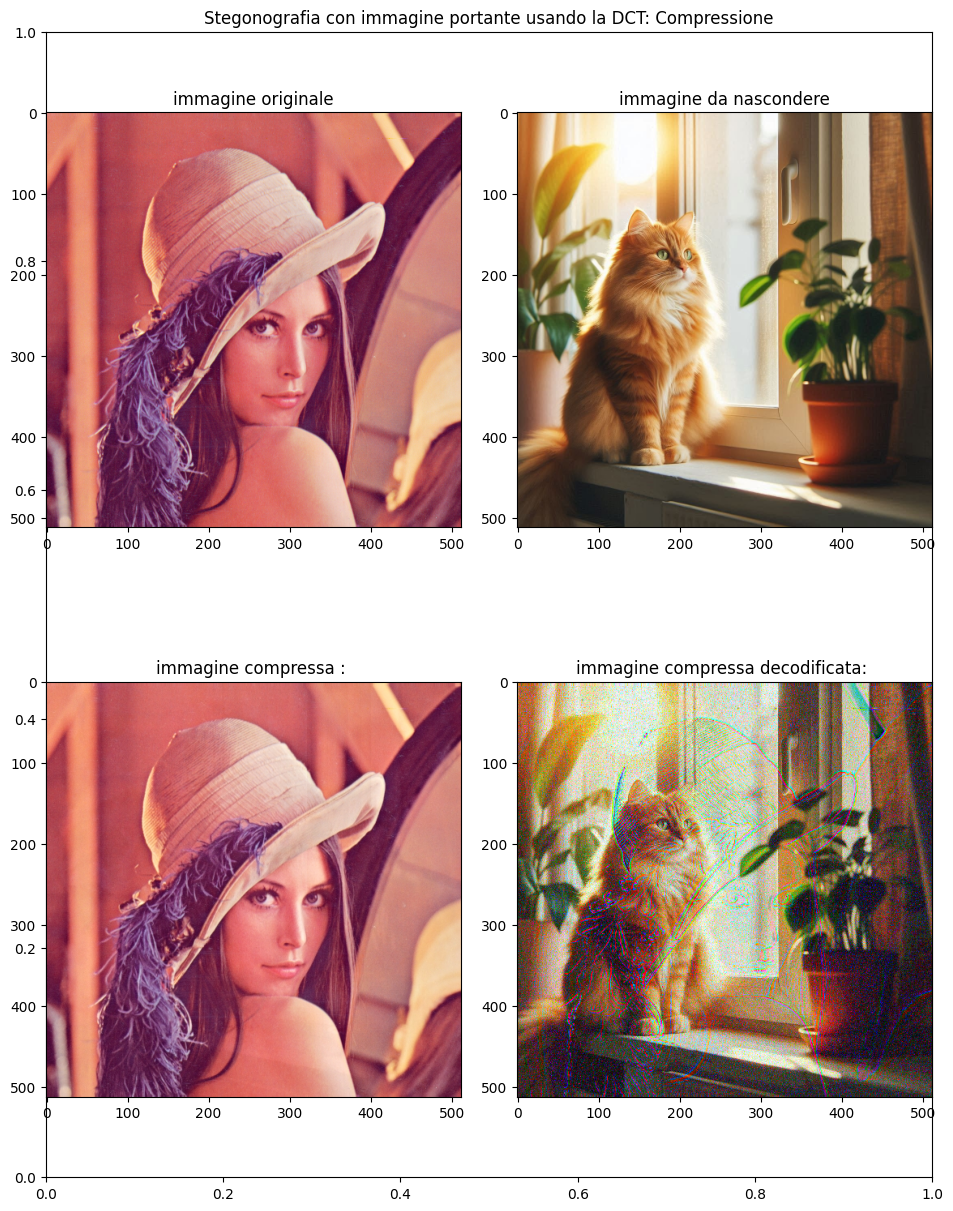

MSE e PSNR immagine portante prima della codifica e dopo la codifica:
l'MSE: 173.15723419189453
psnr: 25.746397205758974
MSE e PSNR immagine da nascondere prima della codifica e dopo la codifica:
l'MSE: 8328.54097366333
psnr: 8.925114342013522


In [14]:
from DCT import Compare
quality_image = 100
compressed_image = compress_image(encoded_img, quality_image) #compressa l'immagine emulando una compressione jpeg
cv2.imwrite("compress_image.jpeg", compressed_image)
decoded_img_after_compression = dct_image.decode_image_with_image(compressed_image, host_img)
cv2.imwrite("decoded_compres_image.jpeg", decoded_img_after_compression)

fig = plt.figure(figsize=(10,12))
rows = 2
columns = 2

plt.title("Stegonografia con immagine portante usando la DCT: Compressione")
fig.add_subplot(rows, columns, 1)
plt.title("immagine originale")
plt.imshow(cv2.cvtColor(host_img, cv2.COLOR_BGR2RGB))
plt.axis('on')

fig.add_subplot(rows, columns, 2)
plt.title("immagine da nascondere")
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.axis('on')


fig.add_subplot(rows, columns, 3)
plt.title("immagine compressa : ")
plt.imshow(cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB))
plt.axis('on')



fig.add_subplot(rows, columns, 4)
plt.title("immagine compressa decodificata: ")
plt.imshow(cv2.cvtColor(decoded_img_after_compression, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.tight_layout()
plt.show()
cmp=Compare()
print("MSE e PSNR immagine portante prima della codifica e dopo la codifica:")
print("l'MSE:",cmp.meanSquareError(host_img,compressed_image))
print("psnr:",cmp.psnr(host_img,compressed_image))

print("MSE e PSNR immagine da nascondere prima della codifica e dopo la codifica:")
print("l'MSE:",cmp.meanSquareError(target_img,decoded_img_after_compression))
print("psnr:",cmp.psnr(decoded_img_after_compression,target_img))

Adesso applichiamo una traslazione per vedere la resistenza della DCT:

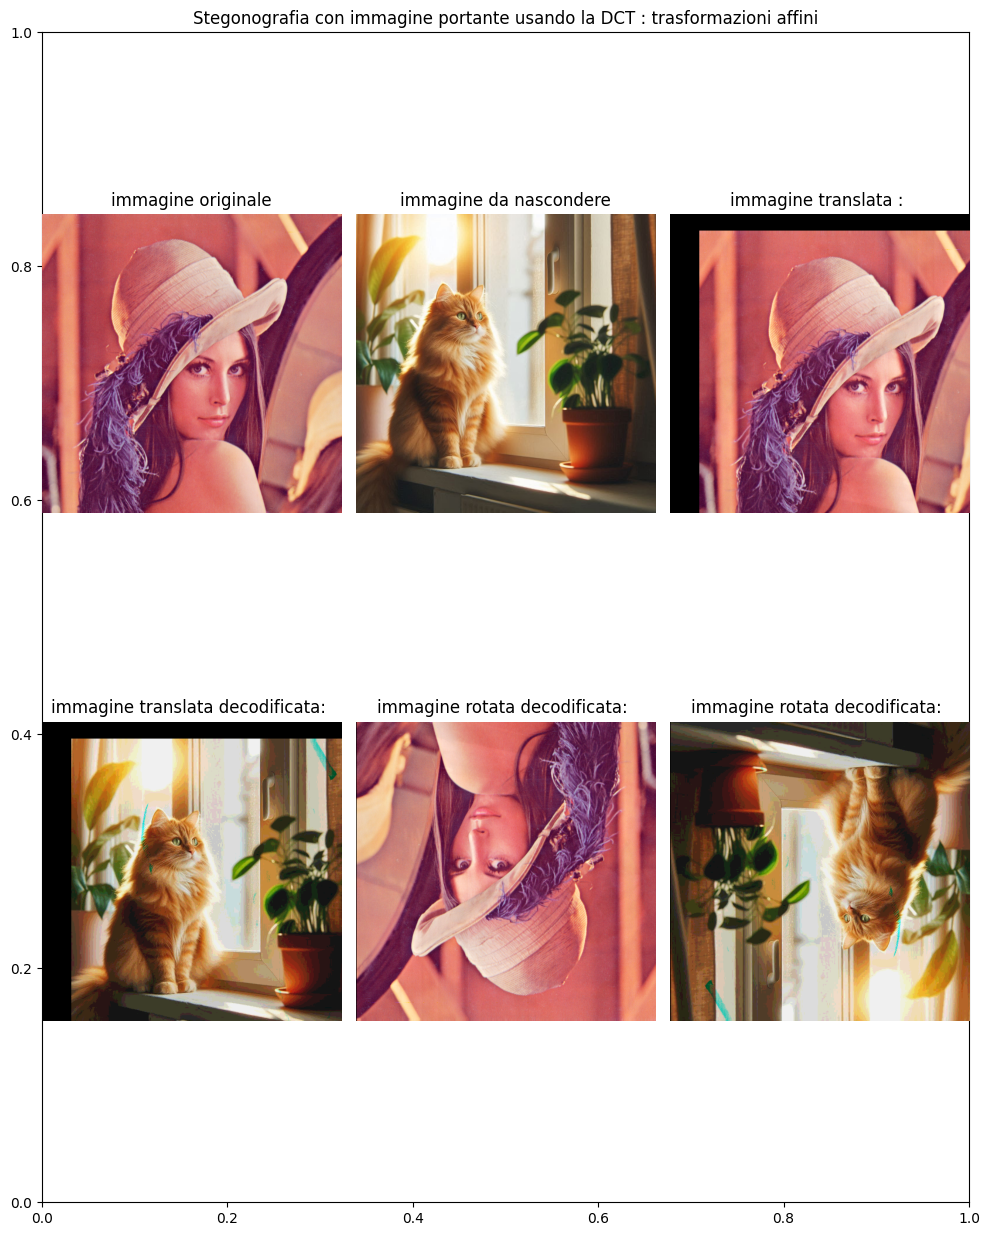

In [15]:
dx,dy=50,30
affine_corrected, M = manual_translation(encoded_img,dx,dy)
cv2.imwrite("affine_corrected.jpeg", affine_corrected)
host_img2, M2 = manual_translation(host_img,dx,dy)
# Decodifica l'immagine corretta
decoded_affine = dct_image.decode_image_with_image(affine_corrected,host_img2)
#decoded_affine = inverse_translation(decoded_affine,M) 
cv2.imwrite("decoded_aff.jpeg", decoded_affine)

#rotato:
rotated_img, M3 = manual_rotation(encoded_img, angle=180)
cv2.imwrite("rotated_img.jpeg", rotated_img)
host_img3, M3 = manual_rotation(host_img, angle=180)
decode_rotate = dct_image.decode_image_with_image(rotated_img,host_img3)


fig = plt.figure(figsize=(10,12))
rows = 2
columns = 3

plt.title("Stegonografia con immagine portante usando la DCT : trasformazioni affini")
fig.add_subplot(rows, columns, 1)
plt.title("immagine originale")
plt.imshow(cv2.cvtColor(host_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.title("immagine da nascondere")
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.axis('off')


fig.add_subplot(rows, columns, 3)
plt.title("immagine translata : ")
plt.imshow(cv2.cvtColor(affine_corrected, cv2.COLOR_BGR2RGB))
plt.axis('off')



fig.add_subplot(rows, columns, 4)
plt.title("immagine translata decodificata: ")
plt.imshow(cv2.cvtColor(decoded_affine, cv2.COLOR_BGR2RGB))
plt.axis('off')
#
fig.add_subplot(rows, columns, 5)
plt.title("immagine rotata decodificata: ")
plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(rows, columns, 6)
plt.title("immagine rotata decodificata: ")
plt.imshow(cv2.cvtColor(decode_rotate, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()